# HOTRG (cytnx version)
## Demo-2
* Author: Pochung Chen
* Last update: 2022/5/16
* Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, Κ κ, Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, Σ σ/ς, Τ τ, Υ υ, Φ φ, Χ χ, Ψ ψ, and Ω ω

Two site Hamiltonian: 
$$ \large
  E(s_1, s_2) = -Js_1 s_2
$$

Boltzmann weight on the bond:
$$ \large
  W = e^{-\beta E} = 
  \left[ \begin{array}{cc}
  e^{+\beta J} & e^{-\beta J} \\
  e^{-\beta J} & e^{+\beta J}
  \end{array} \right]
$$

Decompose $W$ as $M M^\dagger$, where
$$ \large
  W = e^{-\beta E} = M M^\dagger,
  M = 
  \left[ \begin{array}{cc}
  +\sqrt{\cosh{\beta J}} & +\sqrt{\sinh{\beta J}} \\
  +\sqrt{\cosh{\beta J}} & -\sqrt{\sinh{\beta J}}
  \end{array} \right]
$$

Numerically, we first perform SVD on $W$ to obtain $M$ and $M^\dagger$:
$$ \large
  W = U S V^\dagger \rightarrow
  M = U \sqrt{S}, M^\dagger = \sqrt{S} U^\dagger.
$$
Note that because $W$ is Hermitian, on has $V=U$.

$$ \large
  T_{ijkl} = \sum_\alpha
  M_{\alpha, i} M_{\alpha, j} M_{\alpha, k} M_{\alpha, l}
$$

$$ \large
  T_c = \frac{2}{\log(1+\sqrt{2})} \approx 2.269.
$$

## Cytnx cheat sheet

* numpy <-> cytnx.tensor <-> cytnx.UniTensor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cytnx

In [2]:
Tc = 2./np.log(1.+np.sqrt(2))
print(Tc)
def ut_print(ut):
    ut.print_diagram()
    print(ut.get_block().numpy())

2.269185314213022


## Constrauct $M$

In [3]:
def M0_(T):
    M0 = np.array([[+np.sqrt(np.cosh(1/T)), +np.sqrt(np.sinh(1/T))],
                   [+np.sqrt(np.cosh(1/T)), -np.sqrt(np.sinh(1/T))]])
    return M0

def M_(T,h):
    W = np.array([[np.exp(1/T), np.exp(-1/T)],
                  [np.exp(-1/T), np.exp(1/T)]])
    W = cytnx.from_numpy(W)
    # S, U, Vd = cytnx.linalg.Svd(W)
    S, U, Vd = W.Svd()
    M = U @ cytnx.linalg.Diag(S.Pow(0.5))
    Md = cytnx.linalg.Diag(S.Pow(0.5)) @ Vd
    M = cytnx.UniTensor(M, rowrank=1)
    M.set_name('M')
    Md = cytnx.UniTensor(Md, rowrank=1)
    Md.set_name('M†')    
    return M, Md

## Construct $T_{bare}$

In [4]:
def delta_():
    delta = cytnx.zeros([2,2,2,2])
    delta[0,0,0,0]= 1.0
    delta[1,1,1,1]= 1.0
    delta = cytnx.UniTensor(delta, rowrank=2)
    delta.set_name('ẟ')
    return delta

def T_bare_(T, h):
    ut_M, ut_Md = M_(T, h)
    ut_delta = delta_()
    Ising_net = cytnx.Network('Networks/Ising_square.net')
    Ising_net.PutUniTensors(['delta', 'M0.d', 'M1.d', 'M2', 'M3'],
                            [ut_delta, ut_Md, ut_Md, ut_M, ut_M])
    T_bare = Ising_net.Launch(optimal=True)
    T_bare.set_name('T_bare')
    return T_bare

## Single temperature

In [5]:
ut_T = T_bare_(1, 0)
# ut_T.print_diagram()
# ut_T.get_block().numpy()
# ut_print(ut_T)

ymerge_net = cytnx.Network('Networks/merge_two_y.net')
ymerge_net.PutUniTensors(['Tu', 'Td'], [ut_T, ut_T])
ut_Tupdn = ymerge_net.Launch(optimal=True)
ut_Tupdn.print_diagram()
ut_Tupdn.combineBonds([1,2])
ut_Tupdn.print_diagram()
ut_Tupdn.combineBonds([3,4])
ut_Tupdn.print_diagram()
TM = ut_Tupdn.Trace(0, 5, by_label=True)
TM.print_diagram()
TM = TM.get_block()
# print(TM.shape())
# TM.reshape_(4,4)
# print(TM.shape())
λ, _ = cytnx.linalg.Eigh(TM)
λ=λ.numpy()
λ=λ[::-1]
print(λ)
E = -np.log(λ)
print(E)

-----------------------
tensor Name : 
tensor Rank : 6
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 3  
           |             |     
     1 ____| 2         2 |____ 4  
           |             |     
     2 ____| 2         2 |____ 5  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 5
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 3  
           |             |     
     1 ____| 4         2 |____ 4  
           |             |     
           |           2 |____ 5  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------

In [6]:
ut_T = T_bare_(1, 0)
# ut_T.print_diagram()
# ut_T.get_block().numpy()
# ut_print(ut_T)

ymerge_net = cytnx.Network('Networks/merge_two_y.net')
ymerge_net.PutUniTensors(['Tu', 'Td'], [ut_T, ut_T])
ut_Tupdn = ymerge_net.Launch(optimal=True)



ymerge_net_trace = cytnx.Network('Networks/merge_two_y_trace.net')
ymerge_net_trace.PutUniTensors(['Tu', 'Td'], [ut_T, ut_T])

TM = ymerge_net_trace.Launch(optimal=True)
TM.print_diagram()
TM.combineBonds([1,2])
TM.combineBonds([3,4])
TM.print_diagram()

TM = TM.get_block()
# print(TM.shape())
# TM.reshape_(4,4)
# print(TM.shape())
λ, U = cytnx.linalg.Eigh(TM)
λ.numpy()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 2         2 |____ 3  
           |             |     
     2 ____| 2         2 |____ 4  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         4 |____ 3  
           \             /     
            -------------      


array([ 0.94512664,  0.98168436, 53.59815003, 55.67133903])

## Various L

In [7]:
temp = 1.0
h = 0.0
ut_T = T_bare_(temp, h)

T = {}
T[0] = ut_T
T[1] = ut_T
TM = {}

for L in range(2,11):
    print('L={}'.format(L))
    ymerge_net = cytnx.Network('Networks/merge_two_y.net')
    ymerge_net.PutUniTensors(['Tu', 'Td'], [T[L-1], T[1]])
    T[L] = ymerge_net.Launch(optimal=True)
    T[L].combineBonds([1,2])
    T[L].combineBonds([3,4])
    T[L].print_diagram()

    ymerge_net_trace = cytnx.Network('Networks/merge_two_y_trace.net')
    ymerge_net_trace.PutUniTensors(['Tu', 'Td'], [T[L-1], T[1]])    
    TM[L] = ymerge_net_trace.Launch(optimal=True)
    # TM[L].print_diagram()   
    # TM[L]=T[L].Trace(0, 5, by_label=True)
    TM[L] = TM[L].get_block()
    TM[L].reshape_(2**L, 2**L)
    λ, U = cytnx.linalg.Eigh(TM[L])
    λ=λ.numpy()
    λ=λ[::-1]
    print('λ=\n',λ[:4])
    E = -np.log(λ)
    print('E/L=\n',E[:4]/L)

L=2
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ 3  
           |             |     
     1 ____| 4         2 |____ 5  
           \             /     
            -------------      
λ=
 [55.67133903 53.59815003  0.98168436  0.94512664]
E/L=
 [-2.00973273 -1.99075728  0.00924272  0.02821817]
L=3
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         8 |____ 3  
           |             |     
     1 ____| 8         2 |____ 5  
           \             /     
            -------------      
λ=
 [404.96291155 402.73718286   9.14392425   8.23540518]
E/L=
 [-2.00126516 -1.99942807 -0.73769655 -0.70281419]
L=4
-----------------------
tensor Name : 
tensor Rank

In [8]:
h = 0.0

temp_range = np.linspace(2.2, 2.4, 101)
L_range = range(2,6)

λ0 = {}
λ1 = {}
E0 = {}
E1 = {}

for L in L_range:
    λ0[L] = np.zeros_like(temp_range)
    λ1[L] = np.zeros_like(temp_range)
    E0[L] = np.zeros_like(temp_range)
    E1[L] = np.zeros_like(temp_range)

# print(λ0)
    
for i, temp in enumerate(temp_range):
    # print(i, temp)
    ut_T = T_bare_(temp, h)
    T = {}
    T[0] = ut_T
    T[1] = ut_T
    TM = {}

    for L in L_range:
        # print('L={}'.format(L))
        ymerge_net = cytnx.Network('Networks/merge_two_y.net')
        ymerge_net.PutUniTensors(['Tu', 'Td'], [T[L-1], T[1]])
        T[L] = ymerge_net.Launch(optimal=True)
        T[L].combineBonds([1,2])
        T[L].combineBonds([3,4])
        # T[L].print_diagram()

        ymerge_net_trace = cytnx.Network('Networks/merge_two_y_trace.net')
        ymerge_net_trace.PutUniTensors(['Tu', 'Td'], [T[L-1], T[1]])    
        TM[L] = ymerge_net_trace.Launch(optimal=True)
        # TM[L].print_diagram()   
        # TM[L]=T[L].Trace(0, 5, by_label=True)
        TM[L] = TM[L].get_block()
        TM[L].reshape_(2**L, 2**L)
        λ, U = cytnx.linalg.Eigh(TM[L])
        λ=λ.numpy()
        λ=λ[::-1]
        # print('λ=\n',λ[:4])
        E = -np.log(λ)
        # print('E/L=\n',E[:4]/L)
        λ0[L][i] = λ[0]
        λ1[L][i] = λ[1]
        E0[L][i] = E[0]
        E1[L][i] = E[1]        

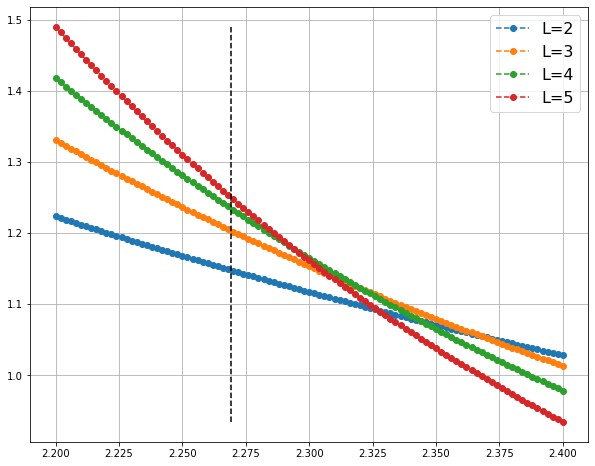

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

for L in  L_range:
    ax.plot(temp_range, 1/((E1[L]-E0[L])*L), 'o--', label='L={}'.format(L))

ax.plot([Tc, Tc], [np.min(1/((E1[L]-E0[L])*L)), np.max(1/((E1[L]-E0[L])*L))],'k--')
ax.legend(fontsize=16)
ax.grid()

In [16]:
h = 0.0

temp_range = np.linspace(2, 3, 11)
L_range = range(2,10)

λ0 = {}
λ1 = {}
E0 = {}
E1 = {}

for L in L_range:
    λ0[L] = np.zeros_like(temp_range)
    λ1[L] = np.zeros_like(temp_range)
    E0[L] = np.zeros_like(temp_range)
    E1[L] = np.zeros_like(temp_range)

# print(λ0)
    
for i, temp in enumerate(temp_range):
    # print(i, temp)
    ut_T = T_bare_(temp, h)
    T = {}
    T[0] = ut_T
    T[1] = ut_T
    TM = {}

    for L in L_range:
        # print('L={}'.format(L))
        ymerge_net = cytnx.Network('Networks/merge_two_y.net')
        ymerge_net.PutUniTensors(['Tu', 'Td'], [T[L-1], T[1]])
        T[L] = ymerge_net.Launch(optimal=True)
        T[L].combineBonds([1,2])
        T[L].combineBonds([3,4])
        # T[L].print_diagram()

        ymerge_net_trace = cytnx.Network('Networks/merge_two_y_trace.net')
        ymerge_net_trace.PutUniTensors(['Tu', 'Td'], [T[L-1], T[1]])    
        TM[L] = ymerge_net_trace.Launch(optimal=True)
        # TM[L].print_diagram()   
        # TM[L]=T[L].Trace(0, 5, by_label=True)
        TM[L] = TM[L].get_block()
        TM[L].reshape_(2**L, 2**L)
        λ, U = cytnx.linalg.Eigh(TM[L])
        λ=λ.numpy()
        λ=λ[::-1]
        # print('λ=\n',λ[:4])
        E = -np.log(λ)
        # print('E/L=\n',E[:4]/L)
        λ0[L][i] = λ[0]
        λ1[L][i] = λ[1]
        E0[L][i] = E[0]
        E1[L][i] = E[1]        

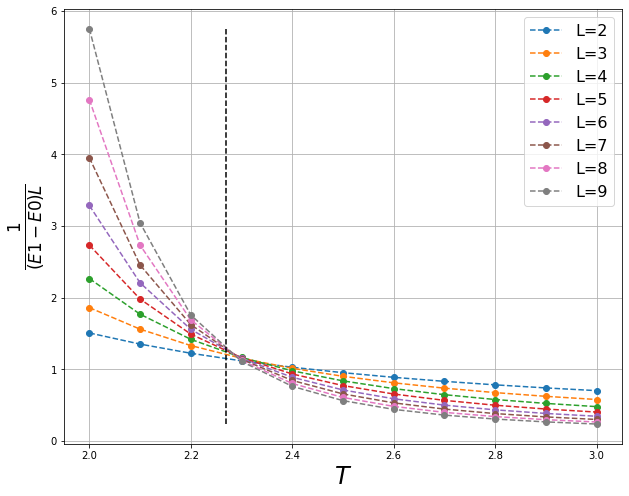

In [17]:
fig, ax = plt.subplots(figsize=(10,8))

for L in  L_range:
    ax.plot(temp_range, 1/((E1[L]-E0[L])*L), 'o--', label='L={}'.format(L))

ax.plot([Tc, Tc], [np.min(1/((E1[L]-E0[L])*L)), np.max(1/((E1[L]-E0[L])*L))],'k--')
ax.set_ylabel(r'$\frac{1}{(E1-E0)L}$', fontsize=24)
ax.set_xlabel(r'$T$', fontsize=24)
ax.legend(fontsize=16)
ax.grid()